# Section 1: Environment & Hardware Setup
**Objective:**  Initialize the deep learning stack and secure a persistent, accelerated computing environment.

**Software Stack:**  We import tensorflow to build the differentiable computation graph and numpy for high-performance tensor operations. Utilities like json and os are included for structured logging and file management.

**Persistence Layer:**  We mount Google Drive to establish a permanent save_path. This allows us to serialize model checkpoints and training history in real-time, mitigating the risk of data loss from Colab's ephemeral runtime.

**Hardware Acceleration:**  The script explicitly validates the availability of a CUDA-enabled GPU (e.g., NVIDIA T4). GPU parallelism is strictly required to accelerate the heavy matrix multiplications inherent in training CNNs.

In [ ]:
import os, random, json, numpy as np, tensorflow as tf
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/Satellite_Project_LAB"
os.makedirs(save_path, exist_ok=True)

print("TensorFlow Version:", tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print("GPU NOT FOUND. Go to Edit > Notebook Settings and select T4 GPU.")
else:
    print(f"Success! Found GPU at: {device_name}")

Mounted at /content/drive
TensorFlow Version: 2.19.0
Success! Found GPU at: /device:GPU:0


# Section 2: Data Acquisition & Preprocessing Pipeline
**Objective:**  Load the EuroSAT dataset and build an optimized tf.data pipeline for efficient model training.

**Dataset Selection:**  We utilize the EuroSAT (RGB) dataset, consisting of 27,000 satellite images across 10 Land Use and Land Cover (LULC) classes. The data is partitioned into 80/10/10 splits for training, validation, and testing.

**Image Standardization:** All images are resized to 224x224 pixels to match the input requirements of the MobileNetV2 architecture. We apply preprocess_input to scale pixel values to the [-1, 1] range, ensuring numerical stability during gradient descent.

**Data Augmentation:**  To improve model generalization and mitigate overfitting, we apply stochastic geometric transformations—including horizontal and vertical flips—to the training set.

**Pipeline Optimization:**

**Vectorized Mapping:**  Preprocessing and augmentation are applied via .map() for efficient element-wise execution.

**Prefetching:**  We use tf.data.AUTOTUNE to overlap data preprocessing with model execution, eliminating CPU bottlenecks.

**Batching & Shuffling:**  Data is shuffled to maintain i.i.d. (independent and identically distributed) properties and batched to optimize throughput on the GPU.

In [ ]:
import tensorflow_datasets as tfds

(train_ds, val_ds, test_ds), info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224
BATCH_SIZE = 64

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

train_ds = train_ds.map(preprocess).map(augment).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Dataset loaded. Classes: {info.features['label'].names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.C3IDMO_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
Dataset loaded. Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


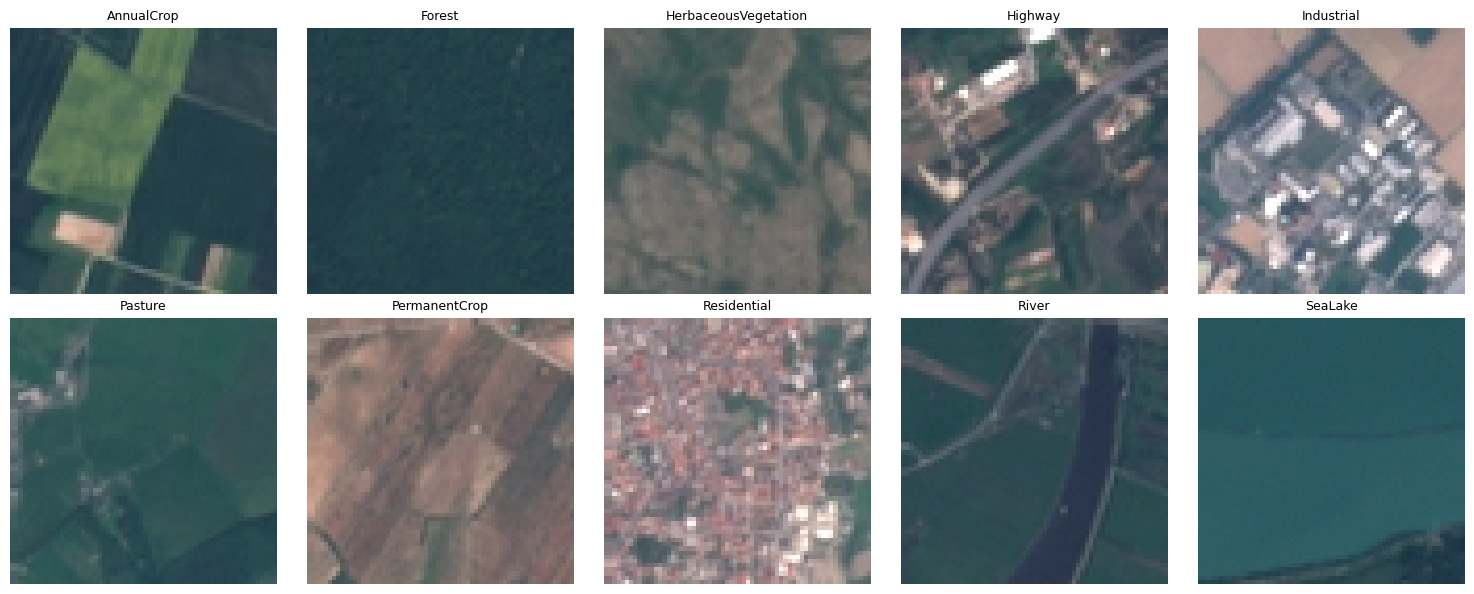

In [ ]:
import matplotlib.pyplot as plt

class_names = info.features['label'].names

# Load a raw (un-preprocessed) train split just for visualization
raw_train = tfds.load('eurosat/rgb', split='train', shuffle_files=False, as_supervised=True)

examples = {}
for img, lbl in raw_train:
    lbl_int = int(lbl.numpy())
    if lbl_int not in examples:
        examples[lbl_int] = img.numpy()
    if len(examples) == len(class_names):
        break

n = len(class_names)
cols = 5
rows = (n + cols - 1) // cols
plt.figure(figsize=(3*cols, 3*rows))
for i, (lbl_int, img_arr) in enumerate(sorted(examples.items())):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img_arr)
    plt.title(class_names[lbl_int], fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Section 3: Model Architecture & Robust Training Strategy
![Model Architecture](imgs/model.png)
## Objective: To develop a family of lightweight models using Transfer Learning and to implement a rigorous statistical framework for performance verification.
### 1. Architectural Foundation: MobileNetV2

For satellite imagery deployment, we require a model that balances high accuracy with a low computational footprint. MobileNetV2 is an optimal choice because it utilizes Inverted Residual Blocks and Depthwise Separable Convolutions. These features significantly reduce the number of parameters and Multiply-Accumulate (MAC) operations compared to standard CNNs, making the architecture highly suitable for resource-constrained edge devices.

Detailed information on these features can be found in the original research paper: [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/pdf/1801.04381).

**1. Depthwise Separable Convolutions**
![Model Architecture](imgs/conv.png)

The core efficiency of MobileNetV2 comes from replacing standard convolutions with Depthwise Separable Convolutions. This process factorizes a traditional convolution into two distinct stages:

* **Depthwise Convolution:** Instead of applying a single filter across all input channels, a separate $k \times k$ filter is applied to each input channel independently.
* **Pointwise Convolution ($1 \times 1$):** A $1 \times 1$ convolution is then used to combine the outputs of the depthwise stage into a new set of output channels.

#### Mathematical Parameter Reduction
Let $h \times w$ be the feature map size, $d_i$ the number of input channels, $d_o$ the output channels, and $k \times k$ the kernel size.

**Standard Convolution Cost:** $$h \cdot w \cdot d_i \cdot d_o \cdot k^2$$

**Depthwise Separable Cost:** $$(h \cdot w \cdot d_i \cdot k^2) + (h \cdot w \cdot d_i \cdot d_o)$$

The Reduction Ratio is calculated as:
$$\frac{\text{Separable Cost}}{\text{Standard Cost}} = \frac{h \cdot w \cdot d_i (k^2 + d_o)}{h \cdot w \cdot d_i \cdot d_o \cdot k^2} = \frac{1}{d_o} + \frac{1}{k^2}$$

For a standard $3 \times 3$ convolution, this results in nearly an 8x to 9x reduction in computational cost and parameters with only a minimal trade-off in accuracy.

---

**2. Inverted Residual Blocks & Linear Bottlenecks**
![Model Architecture](imgs/residuals.png)

In traditional residual blocks (e.g., ResNet), the structure follows a Wide $\rightarrow$ Narrow $\rightarrow$ Wide pattern regarding channel depth. MobileNetV2 flips this convention, using an Inverted Residual structure: Narrow $\rightarrow$ Wide $\rightarrow$ Narrow.

#### The Three-Step Block Structure
* **Expansion Layer ($1 \times 1$):** This layer takes the narrow input and expands it to a higher dimension (controlled by an expansion factor) to allow the model to learn more complex features in a higher-dimensional space.
* **Depthwise Convolution ($3 \times 3$):** This stage performs the actual spatial filtering in that high-dimensional space efficiently.
* **Projection Layer / Linear Bottleneck ($1 \times 1$):** This final stage projects the high-dimensional features back down to a narrow "bottleneck".

#### Why the "Linear" Bottleneck?
The researchers found that applying non-linear activation functions (like ReLU) in narrow layers causes significant information loss. To prevent this, the last $1 \times 1$ layer in the block uses a linear activation, preserving the manifold of interest. By using a narrow "bottleneck" for the skip connections, the model drastically reduces the number of parameters required to store the residuals while maintaining high-precision processing.

---

**3. Implementation Summary**
* **Transfer Learning & Frozen Layers:** We utilize a pre-trained backbone on ImageNet to leverage low-level feature detectors (edges, textures). The base model is frozen (trainable = False), while we train a custom Classification Head consisting of Global Average Pooling, a 20% Dropout layer for regularization, and a 10-class Softmax layer.


---
### 2. The Alpha ($\alpha$) Parameter: Width Scaling

We train models at three different "Width Multipliers" ($\alpha$): 1.0, 0.5, and 0.35.

**Reasoning:** The $\alpha$ parameter uniformly thins the number of filters in each layer. This allows us to explore the Pareto frontier between Model Size and Classification Accuracy, which is critical for choosing the right model for specific satellite hardware constraints.

### 3. Statistical Rigor: Multi-Seed Training

We train each configuration across three different random seeds (1, 2, 3). This practice is conceptually motivated by the Law of Large Numbers (LLN)(https://en.wikipedia.org/wiki/Law_of_large_numbers). While this sample size is not large enough, due to computational constraints, to strictly satisfy the conditions of the LLN, it still provides a more reliable performance estimate than a single run (n=1).

**The Mathematical Reasoning:** Deep Learning training is a stochastic process (random weight initialization, data shuffling). A single training run is a single sample from a distribution of possible outcomes. To report the true performance of an architecture, we need to estimate the Population Mean ($\mu$).

**Law of Large Numbers (LLN) Context:** As the number of experiments ($n$) increases, the sample mean $\bar{X}_n$ converges almost surely to the expected value $\mu$.$$\bar{X}_n = \frac{1}{n} \sum_{i=1}^{n} X_i \xrightarrow{n \to \infty} \mu$$By using multiple seeds, we can calculate the Mean $\pm$ Standard Deviation, ensuring our results are not just "lucky" outliers but statistically significant and reproducible.

**4. Experiment Tracking: JSON History Serialization**

We save all training and validation metrics (Accuracy/Loss) into a JSON-safe format. Why JSON? Unlike binary formats, JSON is a human-readable, language-independent standard.

**Reasoning:**  This allows us to perform "Post-Mortem" analysis and visualization without needing to re-run the computationally expensive training process. We cast values to float to ensure compatibility with standard web-based visualization tools.


In [ ]:
# Section 3 — Train FP32 models (multi-seed, multi-alpha) and save histories (JSON-safe)

from tensorflow.keras import layers, models

seeds = [1, 2, 3]
alphas = [1.0, 0.5, 0.35]
epochs = 15

histories = {a: [] for a in alphas}   # list of history dicts per alpha
fp32_paths = {a: [] for a in alphas}  # model paths per alpha/seed

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def build_model(alpha):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        alpha=alpha
    )
    base.trainable = False
    m = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return m

for alpha in alphas:
    print(f"\n=== Training alpha={alpha} for seeds {seeds} ===")
    for seed in seeds:
        set_seed(seed)
        model = build_model(alpha)
        print(f"\nModel (alpha={alpha}, seed={seed})")
        model.summary()

        hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
        histories[alpha].append(hist.history)

        fp32_file = f"{save_path}/satellite_model_alpha{alpha}_fp32_seed{seed}.h5"
        model.save(fp32_file)
        fp32_paths[alpha].append(fp32_file)
        print(f"Saved: {fp32_file}")

# Convert histories to JSON-safe (cast all values to float) and save
histories_json_safe = {}
for alpha in histories:
    runs = []
    for h in histories[alpha]:
        runs.append({k: [float(x) for x in v] for k, v in h.items()})
    histories_json_safe[alpha] = runs

with open(f"{save_path}/histories.json", "w") as f:
    json.dump(histories_json_safe, f)
print("Saved histories.json (JSON-safe)")


=== Training alpha=1.0 for seeds [1, 2, 3] ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model (alpha=1.0, seed=1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.7365 - loss: 0.7913 - val_accuracy: 0.9111 - val_loss: 0.2550
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9080 - loss: 0.2684 - val_accuracy: 0.9296 - val_loss: 0.2118
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9249 - loss: 0.2188 - val_accuracy: 0.9307 - val_loss: 0.1964
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9319 - loss: 0.2020 - val_accuracy: 0.9378 - val_loss: 0.1785
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.9323 - loss: 0.1969 - val_accuracy: 0.9396 - val_loss: 0.1727
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9330 - loss: 0.1916 - val_accuracy: 0.9389 - val_loss: 0.1721
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9415 - loss: 0.1729 - val_accuracy: 0.9411 - val_loss: 0.1671
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9435 - loss: 0.1666 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed1.h5

Model (alpha=1.0, seed=2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - accuracy: 0.7340 - loss: 0.8138 - val_accuracy: 0.9122 - val_loss: 0.2560
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.9092 - loss: 0.2685 - val_accuracy: 0.9244 - val_loss: 0.2152
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.9229 - loss: 0.2290 - val_accuracy: 0.9300 - val_loss: 0.2017
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.9303 - loss: 0.2071 - val_accuracy: 0.9381 - val_loss: 0.1800
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.9322 - loss: 0.1929 - val_accuracy: 0.9411 - val_loss: 0.1718
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9389 - loss: 0.1795 - val_accuracy: 0.9422 - val_loss: 0.1686
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - accuracy: 0.9399 - loss: 0.1744 - val_accuracy: 0.9341 - val_loss: 0.1821
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9407 - loss: 0.1679 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed2.h5

Model (alpha=1.0, seed=3)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 50s 120ms/step - accuracy: 0.7270 - loss: 0.8261 - val_accuracy: 0.9074 - val_loss: 0.2653
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.9115 - loss: 0.2624 - val_accuracy: 0.9252 - val_loss: 0.2117
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.9247 - loss: 0.2231 - val_accuracy: 0.9337 - val_loss: 0.1926
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9299 - loss: 0.2058 - val_accuracy: 0.9344 - val_loss: 0.1869
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9338 - loss: 0.1904 - val_accuracy: 0.9385 - val_loss: 0.1761
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 29s 83ms/step - accuracy: 0.9366 - loss: 0.1825 - val_accuracy: 0.9352 - val_loss: 0.1793
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9372 - loss: 0.1804 - val_accuracy: 0.9385 - val_loss: 0.1723
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.9398 - loss: 0.1729 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed3.h5

=== Training alpha=0.5 for seeds [1, 2, 3] ===
3201480/3201480 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model (alpha=0.5, seed=1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.50_224            │ (None, 7, 7, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 719,034 (2.74 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 706,224 (2.69 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 66s 140ms/step - accuracy: 0.7379 - loss: 0.7968 - val_accuracy: 0.9163 - val_loss: 0.2522
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 73ms/step - accuracy: 0.9159 - loss: 0.2523 - val_accuracy: 0.9322 - val_loss: 0.2056
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9266 - loss: 0.2114 - val_accuracy: 0.9341 - val_loss: 0.1938
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9339 - loss: 0.1941 - val_accuracy: 0.9348 - val_loss: 0.1841
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9360 - loss: 0.1797 - val_accuracy: 0.9396 - val_loss: 0.1783
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9391 - loss: 0.1726 - val_accuracy: 0.9452 - val_loss: 0.1699
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.9423 - loss: 0.1645 - val_accuracy: 0.9448 - val_loss: 0.1671
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 69ms/step - accuracy: 0.9457 - loss: 0.1562 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed1.h5

Model (alpha=0.5, seed=2)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.50_224            │ (None, 7, 7, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 719,034 (2.74 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 706,224 (2.69 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - accuracy: 0.7384 - loss: 0.7920 - val_accuracy: 0.9181 - val_loss: 0.2475
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.9145 - loss: 0.2532 - val_accuracy: 0.9296 - val_loss: 0.2075
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9287 - loss: 0.2117 - val_accuracy: 0.9311 - val_loss: 0.1972
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9335 - loss: 0.1913 - val_accuracy: 0.9400 - val_loss: 0.1809
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9356 - loss: 0.1815 - val_accuracy: 0.9419 - val_loss: 0.1820
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.9388 - loss: 0.1724 - val_accuracy: 0.9374 - val_loss: 0.1748
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.9405 - loss: 0.1669 - val_accuracy: 0.9459 - val_loss: 0.1665
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9476 - loss: 0.1557 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed2.h5

Model (alpha=0.5, seed=3)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.50_224            │ (None, 7, 7, 1280)     │       706,224 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 719,034 (2.74 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 706,224 (2.69 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step - accuracy: 0.7384 - loss: 0.7804 - val_accuracy: 0.9189 - val_loss: 0.2533
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.9125 - loss: 0.2578 - val_accuracy: 0.9326 - val_loss: 0.2137
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9271 - loss: 0.2127 - val_accuracy: 0.9359 - val_loss: 0.1907
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9325 - loss: 0.1941 - val_accuracy: 0.9441 - val_loss: 0.1795
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.9388 - loss: 0.1797 - val_accuracy: 0.9389 - val_loss: 0.1808
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.9399 - loss: 0.1744 - val_accuracy: 0.9433 - val_loss: 0.1719
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9408 - loss: 0.1662 - val_accuracy: 0.9437 - val_loss: 0.1693
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9449 - loss: 0.1602 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed3.h5

=== Training alpha=0.35 for seeds [1, 2, 3] ===
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model (alpha=0.35, seed=1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_224            │ (None, 7, 7, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,018 (1.61 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 410,208 (1.56 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 55s 124ms/step - accuracy: 0.7407 - loss: 0.8053 - val_accuracy: 0.9104 - val_loss: 0.2591
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9096 - loss: 0.2709 - val_accuracy: 0.9241 - val_loss: 0.2221
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9234 - loss: 0.2271 - val_accuracy: 0.9315 - val_loss: 0.1974
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.9260 - loss: 0.2140 - val_accuracy: 0.9367 - val_loss: 0.1866
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.9295 - loss: 0.2031 - val_accuracy: 0.9389 - val_loss: 0.1799
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.9333 - loss: 0.1926 - val_accuracy: 0.9404 - val_loss: 0.1788
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9324 - loss: 0.1884 - val_accuracy: 0.9459 - val_loss: 0.1700
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.9366 - loss: 0.1809 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed1.h5

Model (alpha=0.35, seed=2)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_224            │ (None, 7, 7, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,018 (1.61 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 410,208 (1.56 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - accuracy: 0.7532 - loss: 0.7645 - val_accuracy: 0.9163 - val_loss: 0.2565
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9118 - loss: 0.2677 - val_accuracy: 0.9300 - val_loss: 0.2139
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9214 - loss: 0.2324 - val_accuracy: 0.9293 - val_loss: 0.2089
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.9263 - loss: 0.2086 - val_accuracy: 0.9396 - val_loss: 0.1866
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.9305 - loss: 0.1993 - val_accuracy: 0.9389 - val_loss: 0.1842
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9332 - loss: 0.1936 - val_accuracy: 0.9400 - val_loss: 0.1864
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.9370 - loss: 0.1826 - val_accuracy: 0.9452 - val_loss: 0.1725
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.9336 - loss: 0.1801 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed2.h5

Model (alpha=0.35, seed=3)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_224            │ (None, 7, 7, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,018 (1.61 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 410,208 (1.56 MB)

Epoch 1/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 48s 108ms/step - accuracy: 0.7307 - loss: 0.8258 - val_accuracy: 0.9159 - val_loss: 0.2585
Epoch 2/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 24s 68ms/step - accuracy: 0.9064 - loss: 0.2710 - val_accuracy: 0.9285 - val_loss: 0.2168
Epoch 3/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.9227 - loss: 0.2269 - val_accuracy: 0.9378 - val_loss: 0.1944
Epoch 4/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9278 - loss: 0.2118 - val_accuracy: 0.9370 - val_loss: 0.1914
Epoch 5/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9329 - loss: 0.1978 - val_accuracy: 0.9374 - val_loss: 0.1872
Epoch 6/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.9358 - loss: 0.1949 - val_accuracy: 0.9411 - val_loss: 0.1765
Epoch 7/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.9382 - loss: 0.1851 - val_accuracy: 0.9430 - val_loss: 0.1704
Epoch 8/15
338/338 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.9387 - loss: 0.1776 -

Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed3.h5
Saved histories.json (JSON-safe)


# Section 4: INT8 Quantization

**Model State Recovery & Path Mapping Objective:** To verify the persistence of the trained FP32 models and re-establish the file-system mapping required for the Post-Training Quantization (PTQ) phase.

**The Engineering Rationale**

Deep learning workflows often require separating the Training and Optimization stages due to resource management, session timeouts, or hardware shifts. This section acts as a bridge:

**Session Decoupling:** By explicitly searching for existing .h5 model files in the save_path, we decouple the training process from the optimization process. This allows the project to remain modular and resilient to environment restarts.

**Validation of Persistence:** The script iterates through every combination of Width Multiplier ($\alpha$) and Random Seed, confirming that each of the 9 experimental models was successfully serialized to Google Drive.

**Dynamic Indexing:** Instead of hardcoding file names, we programmatically build the fp32_paths dictionary. This ensures that the subsequent TFLite conversion scripts have a verified, error-free list of source models to transform.

In [ ]:
# Run this to tell the notebook where your already-trained models are
import os
alphas = [1.0, 0.5, 0.35]
seeds = [1, 2, 3]
fp32_paths = {a: [] for a in alphas}

for a in alphas:
    for s in seeds:
        path = f"{save_path}/satellite_model_alpha{a}_fp32_seed{s}.h5"
        if os.path.exists(path):
            fp32_paths[a].append(path)
            print(f"Found: {path}")
        else:
            print(f"MISSING: {path} - Check your Drive folder!")

Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed1.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed2.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed3.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed1.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed2.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed3.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed1.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed2.h5
Found: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed3.h5


# Section 4 — Post-Training INT8 Quantization & Calibration

**Objective:** To compress the high-precision FP32 models into an 8-bit integer format (INT8), enabling deployment on specialized edge hardware and satellite edge processors / flight hardware with significant performance gains.

### 1. Why INT8?

While our initial models use 32-bit Floating Point (FP32) numbers for training, most edge-computing hardware (like those found in satellite payloads or mobile devices) is optimized for Integer arithmetic. INT8 Quantization is the process of mapping floating-point weights and activations $x \in \mathbb{R}$ into a discrete range of 256 integers $q \in \mathbb{Z}$ (from $-128$ to $127$).

### 2. The Calibration Process: Representative Datasets

Converting to INT8 without data-driven context typically results in significant accuracy degradation. To mitigate this, we implement **Post-training static quantization** via a representative dataset.

**The Problem:** We must determine the dynamic range $[min_x, max_x]$ of activations in each layer to map them to the 8-bit space without excessive clipping.

**The Math:** To perform this mapping, the converter must calculate two parameters for every layer: the **Scale ($S$)** and the **Zero-point ($Z$)**:

1. **Scale ($S$):** Determines the step size of the quantizer.
   $$S = \frac{max_{observed} - min_{observed}}{q_{max} - q_{min}}$$
   *where $q_{max} = 127$ and $q_{min} = -128$ for signed INT8.*

2. **Zero-point ($Z$):** Ensures that the floating-point value $0.0$ is mapped exactly to an integer.
   $$Z = q_{min} - \text{round}\left( \frac{min_{observed}}{S} \right)$$

**Our Solution:** We built a `representative_cache` by sampling 120 images per class from the validation set ($1,200$ images total).

**The Benefit:** This allows the converter to "calibrate" these $S$ and $Z$ values for each layer, theoretically minimizing the quantization noise introduced by the precision reduction.



### 3. Comparative Analysis: Theoretical Trade-offs

| Feature | FP32 (Base) | INT8 (Quantized) | Projected Engineering Impact |
| :--- | :--- | :--- | :--- |
| **Storage Size** | ~9.5MB (Alpha 1.0) | **~2.7MB** | **Theoretical ~4x reduction**; critical for L1/L2 cache residency. |
| **Inference Speed** | Baseline | **Accelerated** | Potential for massive throughput gains on integer-only hardware. |
| **Power Profile** | High | **Low** | Reduced bit-width translates directly to lower orbital power draw. |
| **Accuracy** | Reference | **Stochastic Drop** | Expected variance in precision; sensitive to model width ($\alpha$). |

### 4. Technical Implementation Highlights

We utilize the `TFLiteConverter` to transform the FP32 weights into quantized values using the transformation:

$$q = \text{clamp}\left( \text{round}\left( \frac{x}{S} + Z \right), q_{min}, q_{max} \right)$$

We apply strict constraints to ensure full hardware compatibility:

* **`Optimize.DEFAULT`**: A heuristic-driven approach to balance latency and size.
* **`supported_ops = [TFLITE_BUILTINS_INT8]`**: Enforces a strict integer-only graph, removing reliance on Floating Point Units (FPU).
* **`inference_input_type = tf.int8`**: Optimizes the "first mile" of inference by accepting integer tensors directly, avoiding CPU-bound float-to-int casting at the edge.

In [ ]:
import numpy as np

NUM_CLASSES = 10
CAL_SAMPLES_PER_CLASS = 120  # adjust 80–150 if you need faster/slower

def build_representative_cache(dataset, per_class=CAL_SAMPLES_PER_CLASS, num_classes=NUM_CLASSES):
    counts = [0] * num_classes
    cache = []
    for data, label in dataset.unbatch():  # val_ds is preprocessed, non-augmented
        c = int(label.numpy())
        if counts[c] >= per_class:
            continue
        cache.append(data.numpy())
        counts[c] += 1
        if all(x >= per_class for x in counts):
            break
    return cache

rep_cache = build_representative_cache(val_ds)
print(f"Built representative cache with {len(rep_cache)} samples "
      f"({CAL_SAMPLES_PER_CLASS} per class x {NUM_CLASSES} classes)")

def representative_dataset():
    for arr in rep_cache:
        yield [np.expand_dims(arr, axis=0).astype(np.float32)]

int8_paths = {a: [] for a in alphas}

for alpha in alphas:
    for fp32_file in fp32_paths[alpha]:
        model = tf.keras.models.load_model(fp32_file)
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8

        print(f"Quantizing to INT8: {fp32_file}")
        tflite_int8 = converter.convert()
        int8_file = fp32_file.replace("_fp32_", "_int8_").replace(".h5", ".tflite")
        with open(int8_file, "wb") as f:
            f.write(tflite_int8)
        int8_paths[alpha].append(int8_file)
        print(f"Saved: {int8_file}")

Built representative cache with 1200 samples (120 per class x 10 classes)


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed1.h5
Saved artifact at '/tmp/tmpeidkyum4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960823736272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823736848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823735888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823737616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823736464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823735696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960822330576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960822330768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960823736656: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_int8_seed1.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed2.h5
Saved artifact at '/tmp/tmp0hho13o9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960836959120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836947600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836958160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836958544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836959696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836958928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836959888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836960080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836959312: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_int8_seed2.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed3.h5
Saved artifact at '/tmp/tmp2q3wd7dz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960819166864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819165328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819165520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819165904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819164752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819166288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819165136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819164944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960819167056: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_int8_seed3.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed1.h5
Saved artifact at '/tmp/tmpi37aa8cu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132961318993168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318992016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318992208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318992592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318991440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318978384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318991824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318991632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961318993360: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_int8_seed1.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed2.h5
Saved artifact at '/tmp/tmp_qrwecer'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132961320276176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826572432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826572048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961320287888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826571280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826572624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826571664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826571472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826557456: TensorSpec(shape=(), dtype=tf.r

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_int8_seed2.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed3.h5
Saved artifact at '/tmp/tmp1q1gg7pa'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132961671987024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671985488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671985680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671986064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671984912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671986448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671985104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961671986640: TensorSpec(shape=(), dtype=tf.

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_int8_seed3.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed1.h5
Saved artifact at '/tmp/tmpikc8btdn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960826293712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826292368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826292560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826292944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826291792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826293328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826292176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826291984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960826293520: TensorSpec(shape=(), dtype=tf

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_int8_seed1.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed2.h5
Saved artifact at '/tmp/tmp8_o9c67l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960914275792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914274448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914274640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914275024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914275408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914274256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914274064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914275600: TensorSpec(shape=(), dtype=tf

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_int8_seed2.tflite


Quantizing to INT8: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed3.h5
Saved artifact at '/tmp/tmp5_jcxals'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_17')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960914619856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914618512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914618704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914619088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914617936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914619472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914618320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914618128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960914619664: TensorSpec(shape=(), dtype=tf

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_int8_seed3.tflite


# Section 5: Post-Training Float16 Quantization
**Objective**

To implement Post-Training Quantization (PTQ) by converting high-precision FP32 models into reduced-precision FP16 format. This stage aims to optimize the models for deployment by significantly reducing latency and storage requirements while preserving classification accuracy.

**1. Transitioning from FP32 to FP16**
Standard deep learning models are trained using 32-bit Floating Point (FP32) precision. However, for inference on edge devices, this level of precision often introduces unnecessary computational overhead. By transitioning to 16-bit Floating Point (FP16):

**Bit-Width Reduction:** We reduce the memory footprint of each weight and activation by 50% (from 32 bits to 16 bits).

**Dynamic Range Preservation:** Unlike INT8 quantization, FP16 maintains a floating-point representation (using a 5-bit exponent and 10-bit mantissa). This allows the model to represent a wide range of values, which is critical for maintaining the subtle spectral features present in EuroSAT satellite imagery.

**2. Comparative Analysis: Observed Performance Metrics**

| Metric | FP32 (Base) | FP16 (Optimized) | Engineering Impact |
| :--- | :--- | :--- | :--- |
| **Storage Size** | 100% (~9.55MB) | **~42-47% (~4.49MB)** | **2.1x to 2.5x reduction**; optimizes on-device flash memory residency. |
| **Inference Speed** | Baseline | **Significant Increase** | **9.8x to 23.4x throughput increase** on compatible hardware. |
| **Accuracy Loss** | Reference | **Near-Lossless** | **Negligible drop (0.07 to 0.27 pts)**; preserves model reliability. |
| **Numeric Range** | High | **Sufficient** | Maintains sufficient dynamic range for complex LULC classification. |

**3. Advantages and Disadvantages**

**Advantages**

**Significant Throughput Increase:** By reducing the bit-width, we effectively reduce memory traffic by ~2×. On hardware with FP16 acceleration (such as modern GPUs and specialized NPUs), this results in a substantial reduction in inference time (e.g., reducing latency from ~118ms to ~5ms for $\alpha=0.35$).

**Minimal Accuracy Degradation:** Due to the preservation of the floating-point structure, the "quantization noise" is extremely low. Our results show that the model retains its predictive power across all EuroSAT classes with less than a 0.3% accuracy trade-off.

**Memory Efficiency:** Reducing the model size allows for more efficient caching and lower power consumption during data movement within the hardware architecture.

**Disadvantages**

**Hardware Requirements:** Optimal speedups require hardware that supports FP16 arithmetic (Half-Precision). On older CPUs without dedicated FP16 support, the model may run at FP32 speeds due to software-level emulation.

**4. Technical Implementation Details**

The conversion is performed using the TFLiteConverter with the following configuration:

tf.lite.Optimize.DEFAULT: Enables a suite of optimizations for size and latency.

target_spec.supported_types = [tf.float16]: Explicitly instructs the compiler to cast the 32-bit weights into 16-bit floating-point values.

Unlike INT8 quantization, FP16 conversion does not require a representative dataset because floating-point arithmetic is preserved, eliminating the need for calibration. This makes the optimization pipeline more robust and less prone to the "feature collapse" sometimes observed in integer-only quantization.

In [ ]:
fp16_paths = {a: [] for a in alphas}

for alpha in alphas:
    for fp32_file in fp32_paths[alpha]:
        model = tf.keras.models.load_model(fp32_file)
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]

        print(f"Quantizing to FP16: {fp32_file}")
        tflite_fp16 = converter.convert()
        fp16_file = fp32_file.replace("_fp32_", "_fp16_").replace(".h5", ".tflite")
        with open(fp16_file, "wb") as f:
            f.write(tflite_fp16)
        fp16_paths[alpha].append(fp16_file)
        print(f"Saved: {fp16_file}")

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed1.h5
Saved artifact at '/tmp/tmp08ss24od'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960831847120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960838777936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960838778704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960838767568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960838778128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960838777744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836553808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836554000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960836554384: TensorSpec(shape=(), dtype=tf.r

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed2.h5
Saved artifact at '/tmp/tmpsouqbztu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960825130832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825129872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825130064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825130640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825129296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825117776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825129680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825129488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960825117584: TensorSpec(shape=(), dtype=tf.r

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha1.0_fp32_seed3.h5
Saved artifact at '/tmp/tmpd_m3jybo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960916946384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916945232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916945424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916945808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916946192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916945040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916944848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960916946768: TensorSpec(shape=(), dtype=tf.r

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed1.h5
Saved artifact at '/tmp/tmp0oi4t099'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132962680211216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915438864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915439056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132962680224464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915438288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915439248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915438672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915438480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960915424272: TensorSpec(shape=(), dtype=tf.r

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed2.h5
Saved artifact at '/tmp/tmpku8bq_to'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960828227024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828225872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828226064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828226448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828225296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828226832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828225680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828225488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960828227408: TensorSpec(shape=(), dtype=tf.r

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.5_fp32_seed3.h5
Saved artifact at '/tmp/tmp66b15bcm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_11')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132961321614800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321613648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321613840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321614224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321613072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321614608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321613456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321613264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961321615184: TensorSpec(shape=(), dtype=tf.

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed1.h5
Saved artifact at '/tmp/tmp7665oc33'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_13')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960821132752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821131600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821131792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821132176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821131024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821132560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821131408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821131216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960821133136: TensorSpec(shape=(), dtype=tf

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed2.h5
Saved artifact at '/tmp/tmpeur3y_se'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132961324023248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324022096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324022288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324022672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324021520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324023056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324021904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324021712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132961324023632: TensorSpec(shape=(), dtype=tf

Quantizing to FP16: /content/drive/MyDrive/Satellite_Project_LAB/satellite_model_alpha0.35_fp32_seed3.h5
Saved artifact at '/tmp/tmpgx6a1q5_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_17')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132960839138768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839137616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839137808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839138192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839137040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839138576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839137424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839137232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132960839139152: TensorSpec(shape=(), dtype=tf

# Section 6: Evaluation

#Optimized Asset Verification & Path Mapping

**Objective:** To verify the persistent storage of all optimized INT8 and FP16 TFLite models and re-establish file-system indexing required for the final multi-metric evaluation.

**The Engineering Rationale**

**Quantized Asset Recovery:** This step ensures that the 18 optimized variants (3 alphas × 3 seeds × 2 formats) generated in the previous phase are correctly serialized and accessible, preventing session-loss errors.

**Pipeline Decoupling:** By re-indexing the assets at the start of Section 6, the evaluation remains independent of the quantization process, allowing for modular testing and easier data recovery.

**Automated Indexing:** The script programmatically populates the int8_paths and fp16_paths dictionaries, ensuring the subsequent evaluation loops can automatically iterate through every model variant without manual path entry.

In [ ]:
import os

# Ensure these lists are ready
alphas = [1.0, 0.5, 0.35]
seeds = [1, 2, 3]

# Initialize the path dictionaries
int8_paths = {a: [] for a in alphas}
fp16_paths = {a: [] for a in alphas}

print("--- Searching for saved models in Drive ---")

for a in alphas:
    for s in seeds:
        # 1. Check for INT8 (.tflite)
        int8_file = f"{save_path}/satellite_model_alpha{a}_int8_seed{s}.tflite"
        if os.path.exists(int8_file):
            int8_paths[a].append(int8_file)
        else:
            print(f"MISSING INT8: alpha {a} seed {s}")

        # 2. Check for FP16 (.tflite)
        fp16_file = f"{save_path}/satellite_model_alpha{a}_fp16_seed{s}.tflite"
        if os.path.exists(fp16_file):
            fp16_paths[a].append(fp16_file)
        else:
            print(f"MISSING FP16: alpha {a} seed {s}")

print("\nScan Complete!")
print(f"Found {sum(len(v) for v in int8_paths.values())} INT8 models.")
print(f"Found {sum(len(v) for v in fp16_paths.values())} FP16 models.")

--- Searching for saved models in Drive ---

Scan Complete!
Found 9 INT8 models.
Found 9 FP16 models.


# Multi-Objective Evaluation & Weighted Selection

**Objective:** To quantitatively evaluate all 27 model variations and identify the optimal candidate for satellite deployment using a mathematically grounded scoring system that balances **Accuracy**, **Latency**, and **Storage Size**.

---

### 1. The Evaluation Framework
To ensure statistical significance, we evaluate each of the three seeds for every combination of width multiplier ($\alpha$) and precision format. Two distinct evaluation functions are utilized:

* **`evaluate_fp32_latency`**: Benchmarks the original Keras `.h5` models.
* **`evaluate_tflite`**: Benchmarks the optimized `.tflite` models. This function specifically handles **INT8 data scaling**, converting image tensors to 8-bit integers using the scale and zero-point metadata calculated during calibration.

---

### 2. Weighted Multi-Objective Scoring
In orbital edge computing, a model that is 99% accurate but takes 2 seconds to run is as ineffective as a model that is 10% accurate but takes 1ms. We use **Min-Max Normalization** and a **Weighted Sum Model** to find the "Pareto Optimal" candidate.

#### Step A: Normalization
Because Accuracy ($0.0–1.0$), Latency (ms), and Size (MB) have different scales and units, we must normalize them to a range of $[0, 1]$.

* **Accuracy ($A_n$):** Higher is better (Benefit criteria).
    $$A_n = \frac{Acc - Acc_{min}}{Acc_{max} - Acc_{min}}$$
* **Latency ($L_n$) & Size ($S_n$):** Lower is better (Cost criteria). We invert these so that a value of $1.0$ represents the "best" (lowest) value.
  $$L_n = \frac{Lat_{max} - Lat}{Lat_{max} - Lat_{min}}$$

  $$S_n = \frac{Size_{max} - Size}{Size_{max} - Size_{min}}$$

#### Step B: The Final Score Calculation
We assign weights based on the deployment priority. For this satellite project, we prioritize **Efficiency** (Latency and Size) slightly over marginal accuracy gains:
$$\text{Score} = (0.30 \times A_n) + (0.35 \times L_n) + (0.35 \times S_n)$$



---

### 3. Why This Approach?
* **Engineering Rigor:** It moves the decision-making process from "subjective guessing" to "data-driven selection."
* **Deployment Constraints:** The 70% combined weight on Latency and Size reflects the reality of satellite hardware, where power and memory are strictly limited.
* **Statistical Stability:** By calculating the **Mean** and **Standard Deviation** across three different seeds, we ensure that the "Winner" is a robust architecture rather than a result of fortunate weight initialization.

---

### 4. Result Interpretation Logic
The script outputs two critical rankings:
1.  **Averaged Winner:** The $\alpha$ and precision variant that performs best on average across all seeds.
2.  **Top Individual Asset:** The specific seed within that winning group that achieved the highest individual accuracy, designated as our **"Flight-Ready"** model.

In [ ]:
# Section 6 — Evaluation with weighted multi-objective selection

import time, os, pandas as pd

def evaluate_tflite(model_path, dataset, max_samples=500):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    is_int8 = input_details['dtype'] == np.int8
    scale, zero_point = input_details['quantization'] if is_int8 else (1.0, 0)

    correct, total = 0, 0
    start_time = time.time()
    for images, labels in dataset.unbatch().take(max_samples):
        img = images.numpy()
        if is_int8:
            img_q = np.round(img / scale + zero_point).astype(np.int8)
            interpreter.set_tensor(input_details['index'], np.expand_dims(img_q, axis=0))
        else:
            interpreter.set_tensor(input_details['index'], np.expand_dims(img, axis=0))
        interpreter.invoke()
        output = interpreter.get_tensor(output_details['index'])
        pred = np.argmax(output)
        if pred == labels.numpy():
            correct += 1
        total += 1
    end_time = time.time()
    return (correct / total), ((end_time - start_time) / total * 1000)

def evaluate_fp32_latency(model, dataset, max_samples=500):
    correct, total = 0, 0
    start_time = time.time()
    for images, labels in dataset.unbatch().take(max_samples):
        preds = model.predict(np.expand_dims(images.numpy(), axis=0), verbose=0)
        pred = np.argmax(preds, axis=1)[0]
        if pred == labels.numpy():
            correct += 1
        total += 1
    end_time = time.time()
    return (correct / total), ((end_time - start_time) / total * 1000)

# Collect per-seed metrics
per_seed = []
for alpha in alphas:
    for fp32_file, int8_file, fp16_file in zip(fp32_paths[alpha], int8_paths[alpha], fp16_paths[alpha]):
        mdl = tf.keras.models.load_model(fp32_file)
        fp32_acc, fp32_lat = evaluate_fp32_latency(mdl, test_ds)
        int8_acc, int8_lat = evaluate_tflite(int8_file, test_ds)
        fp16_acc, fp16_lat = evaluate_tflite(fp16_file, test_ds)
        per_seed.append({
            "alpha": alpha,
            "seed": fp32_file.split("seed")[-1].split(".")[0],
            "fp32_acc": fp32_acc, "fp32_lat": fp32_lat, "fp32_size": os.path.getsize(fp32_file)/1e6, "fp32_path": fp32_file,
            "int8_acc": int8_acc, "int8_lat": int8_lat, "int8_size": os.path.getsize(int8_file)/1e6, "int8_path": int8_file,
            "fp16_acc": fp16_acc, "fp16_lat": fp16_lat, "fp16_size": os.path.getsize(fp16_file)/1e6, "fp16_path": fp16_file,
        })

df = pd.DataFrame(per_seed)

def agg_stats(sub, prefix):
    return {
        "mean_acc": sub[f"{prefix}_acc"].mean(),
        "std_acc": sub[f"{prefix}_acc"].std(),
        "mean_lat": sub[f"{prefix}_lat"].mean(),
        "std_lat": sub[f"{prefix}_lat"].std(),
        "mean_size": sub[f"{prefix}_size"].mean(),
        "std_size": sub[f"{prefix}_size"].std(),
    }

# Aggregate mean/std per alpha and variant
agg = {}
for alpha in alphas:
    sub = df[df.alpha == alpha]
    agg[alpha] = {
        "fp32": agg_stats(sub, "fp32"),
        "fp16": agg_stats(sub, "fp16"),
        "int8": agg_stats(sub, "int8"),
    }

# Build a flat list of averaged models for scoring
avg_models = []
for alpha in agg:
    for variant in ["fp32", "fp16", "int8"]:
        m = agg[alpha][variant]
        avg_models.append({
            "alpha": alpha,
            "variant": variant,
            "mean_acc": m["mean_acc"],
            "mean_lat": m["mean_lat"],
            "mean_size": m["mean_size"],
        })

# Compute min/max for normalization
acc_vals  = [m["mean_acc"]  for m in avg_models]
lat_vals  = [m["mean_lat"]  for m in avg_models]
size_vals = [m["mean_size"] for m in avg_models]
acc_min, acc_max = min(acc_vals), max(acc_vals)
lat_min, lat_max = min(lat_vals), max(lat_vals)
size_min, size_max = min(size_vals), max(size_vals)

def norm_up(x, xmin, xmax):
    return 0.0 if xmax == xmin else (x - xmin) / (xmax - xmin)

def norm_down(x, xmin, xmax):
    # higher is better, so invert for latency/size
    return 0.0 if xmax == xmin else (xmax - x) / (xmax - xmin)

# Weighted multi-objective score
# Score = 0.30 * A_n + 0.35 * L_n + 0.35 * S_n
for m in avg_models:
    A_n = norm_up(m["mean_acc"], acc_min, acc_max)
    L_n = norm_down(m["mean_lat"], lat_min, lat_max)
    S_n = norm_down(m["mean_size"], size_min, size_max)
    m["score"] = 0.30 * A_n + 0.35 * L_n + 0.35 * S_n
    m["A_n"] = A_n; m["L_n"] = L_n; m["S_n"] = S_n

# Pick best averaged model by highest score
best_avg = max(avg_models, key=lambda x: x["score"])
best_alpha, best_variant = best_avg["alpha"], best_avg["variant"]

# Among that alpha+variant, pick best seed by highest accuracy (then lower latency)
best_row = None
for _, row in df[df.alpha == best_alpha].iterrows():
    acc = row[f"{best_variant}_acc"]
    lat = row[f"{best_variant}_lat"]
    if (best_row is None) or (acc > best_row["acc"]) or (acc == best_row["acc"] and lat < best_row["lat"]):
        best_row = {"acc": acc, "lat": lat, "row": row}

best_model_path = best_row["row"][f"{best_variant}_path"]

# Print mean/std and deltas vs FP32 of same alpha (speed, size, accuracy change)
print("\n=== Mean/Std by alpha & variant ===")
for alpha in alphas:
    base = agg[alpha]["fp32"]
    base_acc, base_lat, base_size = base["mean_acc"], base["mean_lat"], base["mean_size"]
    for variant in ["fp32","fp16","int8"]:
        m = agg[alpha][variant]
        acc = m["mean_acc"]*100
        lat = m["mean_lat"]
        size = m["mean_size"]
        std_acc = m["std_acc"]*100
        std_lat = m["std_lat"]
        std_size = m["std_size"]
        print(f"alpha={alpha}, {variant}: Acc {acc:.2f}±{std_acc:.2f} %, "
              f"Lat {lat:.2f}±{std_lat:.2f} ms, Size {size:.2f}±{std_size:.2f} MB")
        if variant != "fp32":
            acc_delta = (m["mean_acc"] - base_acc) * 100
            speedup   = base_lat / lat if lat > 0 else float('inf')
            size_red  = base_size / size if size > 0 else float('inf')
            print(f"    vs FP32 (same alpha): ΔAcc {acc_delta:.2f} pts, "
                  f"Speedup {speedup:.2f}x, Size reduction {size_red:.2f}x")

print("\n=== Weighted scores (A_n, L_n, S_n, Score) ===")
for m in sorted(avg_models, key=lambda x: -x["score"]):
    print(f"alpha={m['alpha']}, {m['variant']}: "
          f"A_n={m['A_n']:.3f}, L_n={m['L_n']:.3f}, S_n={m['S_n']:.3f}, "
          f"Score={m['score']:.3f}")

print(f"\nBest averaged model by weighted score: alpha={best_alpha}, variant={best_variant}, "
      f"Score={best_avg['score']:.3f}")

print("Best single model within that averaged winner (by seed, highest acc then lower lat):")
print(best_row["row"])
print(f"\nUse this for confusion matrix: {best_model_path}")

# (Comment: Score = 0.30 * A_n + 0.35 * L_n + 0.35 * S_n,
#  where A_n = (Acc - Acc_min)/(Acc_max - Acc_min),
#        L_n = (Lat_max - Lat)/(Lat_max - Lat_min),
#        S_n = (Size_max - Size)/(Size_max - Size_min))

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



=== Mean/Std by alpha & variant ===
alpha=1.0, fp32: Acc 93.60±0.53 %, Lat 148.12±5.99 ms, Size 9.55±0.00 MB
alpha=1.0, fp16: Acc 93.47±0.70 %, Lat 15.06±1.42 ms, Size 4.49±0.00 MB
    vs FP32 (same alpha): ΔAcc -0.13 pts, Speedup 9.84x, Size reduction 2.13x
alpha=1.0, int8: Acc 83.47±1.33 %, Lat 21.05±1.40 ms, Size 2.72±0.00 MB
    vs FP32 (same alpha): ΔAcc -10.13 pts, Speedup 7.04x, Size reduction 3.51x
alpha=0.5, fp32: Acc 94.07±0.64 %, Lat 124.07±6.94 ms, Size 3.35±0.00 MB
alpha=0.5, fp16: Acc 94.00±0.40 %, Lat 7.65±1.93 ms, Size 1.43±0.00 MB
    vs FP32 (same alpha): ΔAcc -0.07 pts, Speedup 16.23x, Size reduction 2.34x
alpha=0.5, int8: Acc 53.27±1.40 %, Lat 11.00±1.39 ms, Size 0.98±0.00 MB
    vs FP32 (same alpha): ΔAcc -40.80 pts, Speedup 11.28x, Size reduction 3.40x
alpha=0.35, fp32: Acc 93.47±0.31 %, Lat 117.92±4.67 ms, Size 2.16±0.00 MB
alpha=0.35, fp16: Acc 93.20±0.20 %, Lat 5.02±0.16 ms, Size 0.85±0.00 MB
    vs FP32 (same alpha): ΔAcc -0.27 pts, Speedup 23.48x, Size reduc

# Section 7: Plots

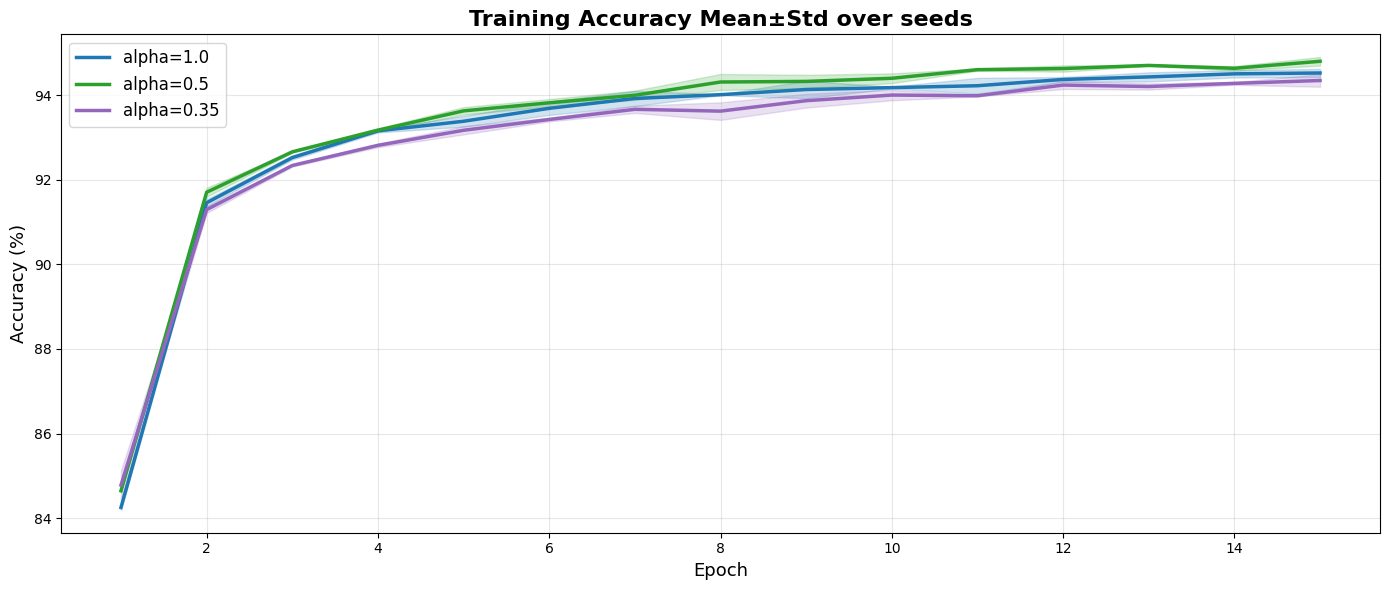

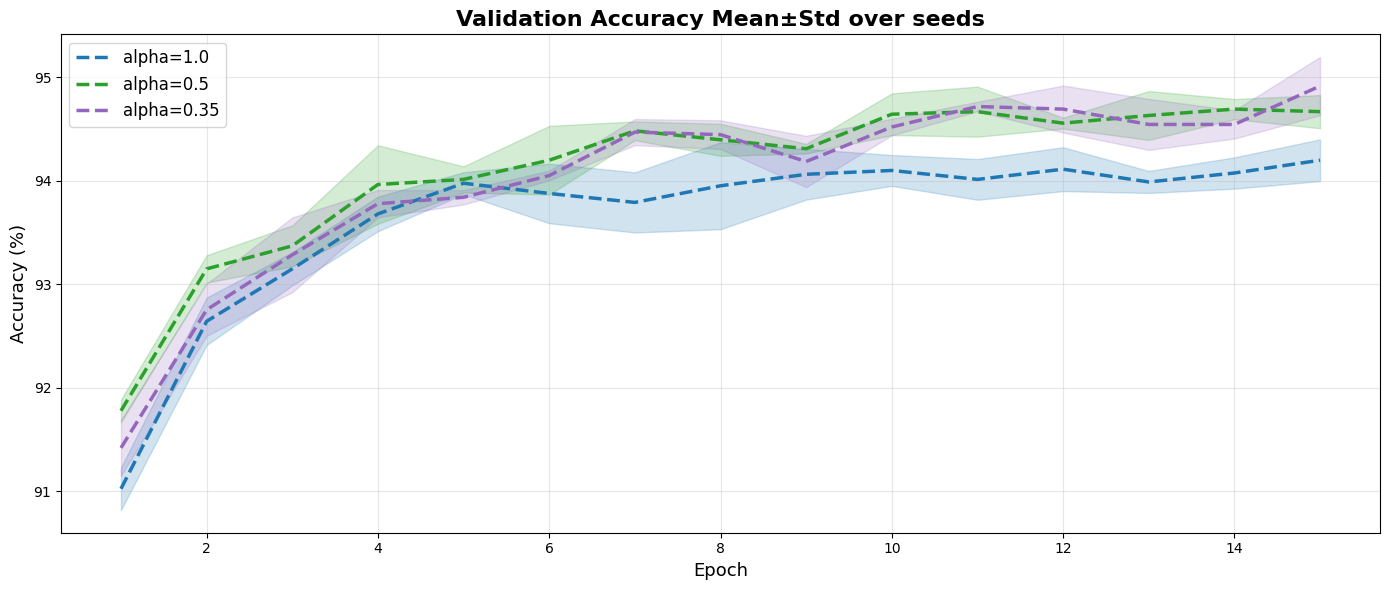

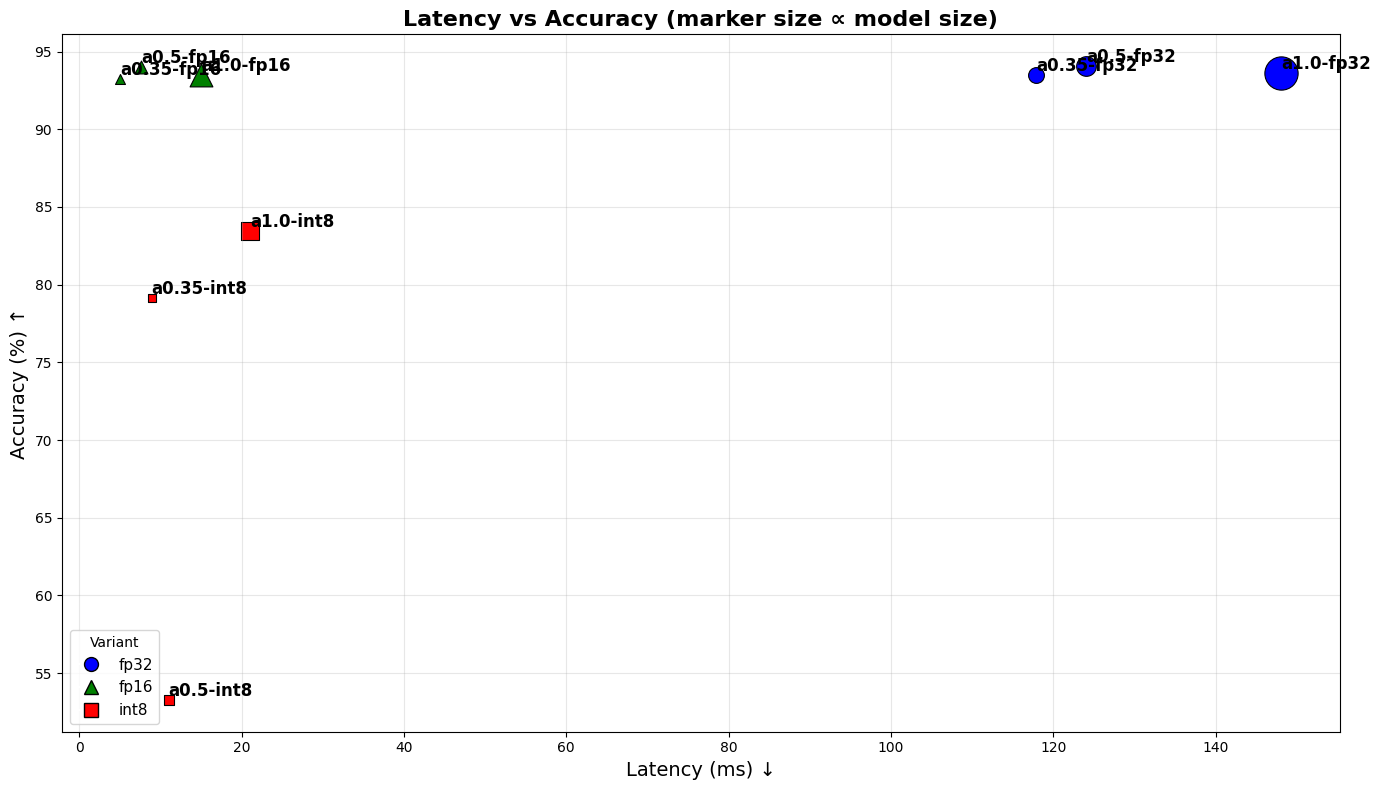

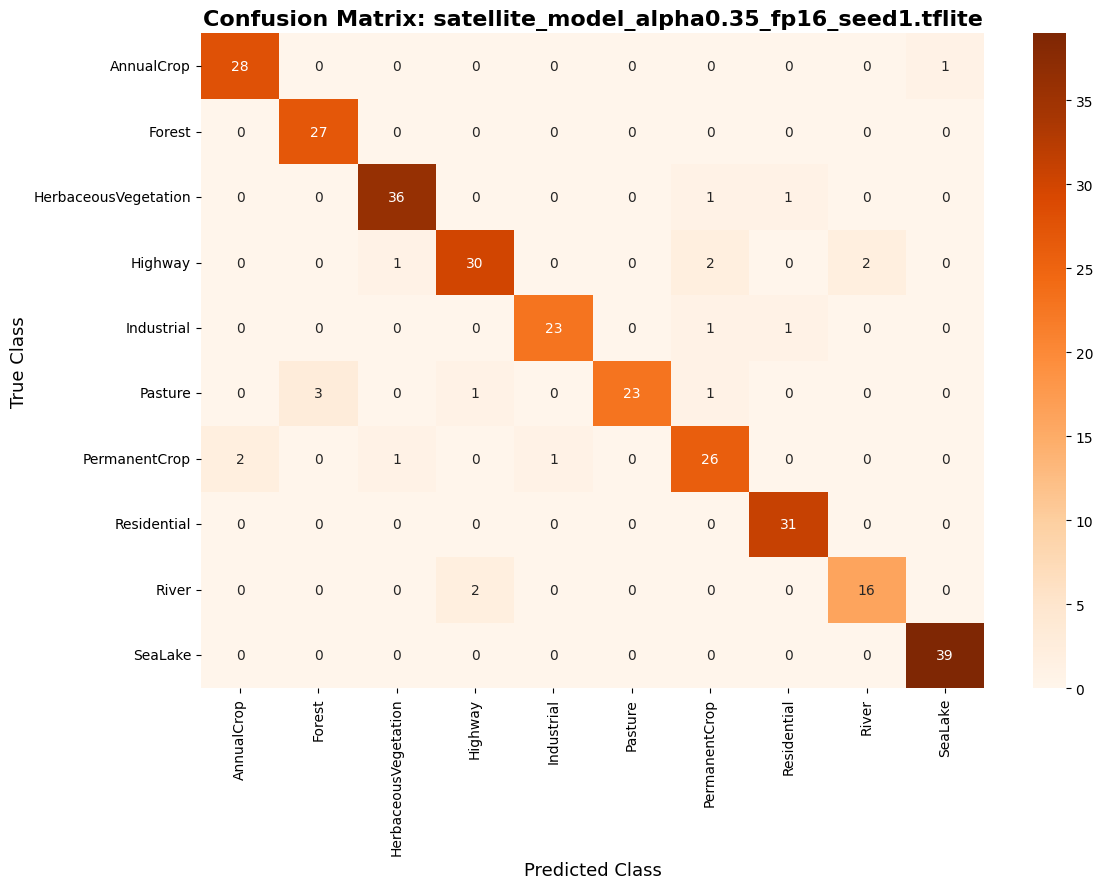

In [ ]:
# Section 7 — Plots (separate train/val, larger figs, 2D trade-off, orange CM)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Reload histories if not in memory, normalize keys to float
if 'histories' not in globals():
    with open(f"{save_path}/histories.json", "r") as f:
        h = json.load(f)
    histories = h
histories = {float(k): v for k, v in histories.items()}

# If alphas not in scope, derive from histories
if 'alphas' not in globals():
    alphas = sorted(histories.keys())

# Consistent colors per alpha
palette = {
    alphas[0]: sns.color_palette("tab10")[0],
    alphas[1]: sns.color_palette("tab10")[2],
    alphas[2]: sns.color_palette("tab10")[4],
}

def plot_mean_std_single(histories, alphas, metric='accuracy', title='Train Accuracy'):
    plt.figure(figsize=(14, 6))
    for alpha in alphas:
        accs = np.stack([h[metric] for h in histories[alpha]], axis=0)
        mean_acc, std_acc = accs.mean(0), accs.std(0)
        epochs_range = np.arange(1, len(mean_acc)+1)
        c = palette[alpha]
        plt.plot(epochs_range, mean_acc*100, label=f'alpha={alpha}', lw=2.5, color=c)
        plt.fill_between(epochs_range, (mean_acc-std_acc)*100, (mean_acc+std_acc)*100,
                         color=c, alpha=0.20)
    plt.title(f'{title} Mean±Std over seeds', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=13); plt.ylabel('Accuracy (%)', fontsize=13)
    plt.grid(True, alpha=0.3); plt.legend(fontsize=12)
    plt.tight_layout(); plt.show()

def plot_mean_std_train_val(histories, alphas):
    # Train
    plot_mean_std_single(histories, alphas, metric='accuracy', title='Training Accuracy')
    # Val
    plt.figure(figsize=(14, 6))
    for alpha in alphas:
        accs = np.stack([h['val_accuracy'] for h in histories[alpha]], axis=0)
        mean_acc, std_acc = accs.mean(0), accs.std(0)
        epochs_range = np.arange(1, len(mean_acc)+1)
        c = palette[alpha]
        plt.plot(epochs_range, mean_acc*100, label=f'alpha={alpha}', lw=2.5, color=c, linestyle='--')
        plt.fill_between(epochs_range, (mean_acc-std_acc)*100, (mean_acc+std_acc)*100,
                         color=c, alpha=0.20)
    plt.title('Validation Accuracy Mean±Std over seeds', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=13); plt.ylabel('Accuracy (%)', fontsize=13)
    plt.grid(True, alpha=0.3); plt.legend(fontsize=12)
    plt.tight_layout(); plt.show()

plot_mean_std_train_val(histories, alphas)

# 2D trade-off plot: Latency (x) vs Accuracy (y), marker size ~ model size, label bold
def plot_tradeoffs_2d(agg):
    plt.figure(figsize=(14, 8))
    colors = {'fp32':'blue','fp16':'green','int8':'red'}
    markers = {'fp32':'o','fp16':'^','int8':'s'}
    for alpha in agg:
        for variant in ['fp32','fp16','int8']:
            m = agg[alpha][variant]
            acc = m['mean_acc']*100
            lat = m['mean_lat']
            size = m['mean_size']
            plt.scatter(lat, acc, s=max(40, size*60), color=colors[variant],
                        marker=markers[variant], edgecolor='k', linewidth=0.8)
            plt.text(lat, acc, f"a{alpha}-{variant}", fontsize=12, fontweight='bold',
                     ha='left', va='bottom')
    plt.xlabel('Latency (ms) ↓', fontsize=14)
    plt.ylabel('Accuracy (%) ↑', fontsize=14)
    plt.title('Latency vs Accuracy (marker size ∝ model size)', fontsize=16, fontweight='bold')
    # Custom legend
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], marker='o', color='w', label='fp32', markerfacecolor='blue', markersize=10, markeredgecolor='k'),
        Line2D([0],[0], marker='^', color='w', label='fp16', markerfacecolor='green', markersize=10, markeredgecolor='k'),
        Line2D([0],[0], marker='s', color='w', label='int8', markerfacecolor='red', markersize=10, markeredgecolor='k'),
    ]
    plt.legend(handles=legend_elems, title='Variant', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

plot_tradeoffs_2d(agg)

# Confusion matrix for the best model (orange colormap)
def plot_confusion_matrix_model(model_path, dataset, class_names, max_samples=300, variant='fp32'):
    y_true, y_pred = [], []
    if variant == 'fp32':
        mdl = tf.keras.models.load_model(model_path)
        for images, labels in dataset.unbatch().take(max_samples):
            preds = mdl.predict(np.expand_dims(images.numpy(), axis=0), verbose=0)
            y_true.append(labels.numpy())
            y_pred.append(np.argmax(preds, axis=1)[0])
    else:
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        is_int8 = input_details['dtype'] == np.int8
        scale, zero_point = input_details['quantization'] if is_int8 else (1.0, 0)
        for images, labels in dataset.unbatch().take(max_samples):
            img = images.numpy()
            if is_int8:
                img_q = np.round(img / scale + zero_point).astype(np.int8)
                interpreter.set_tensor(input_details['index'], np.expand_dims(img_q, axis=0))
            else:
                interpreter.set_tensor(input_details['index'], np.expand_dims(img, axis=0))
            interpreter.invoke()
            output = interpreter.get_tensor(output_details['index'])
            y_true.append(labels.numpy())
            y_pred.append(np.argmax(output))

    # Make cm global so Section 8 can use it
    global cm
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))

    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {os.path.basename(model_path)}', fontsize=16, fontweight='bold')
    plt.ylabel('True Class', fontsize=13); plt.xlabel('Predicted Class', fontsize=13)
    plt.tight_layout(); plt.show()

plot_confusion_matrix_model(
    best_model_path,
    test_ds,
    info.features['label'].names,
    max_samples=300,
    variant='fp32' if best_variant=='fp32' else 'tflite'
)

# Section 8

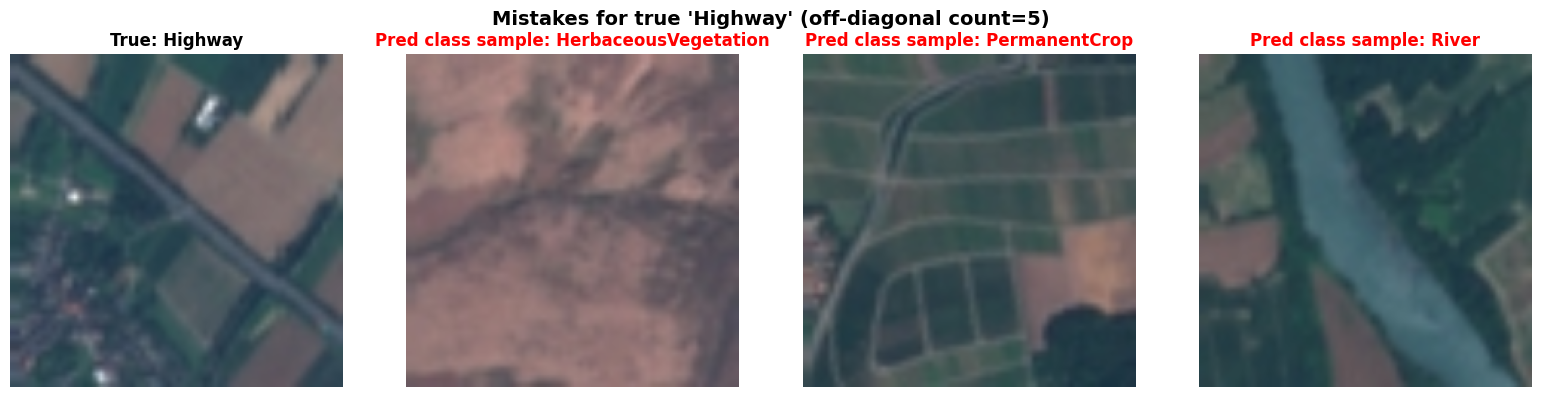

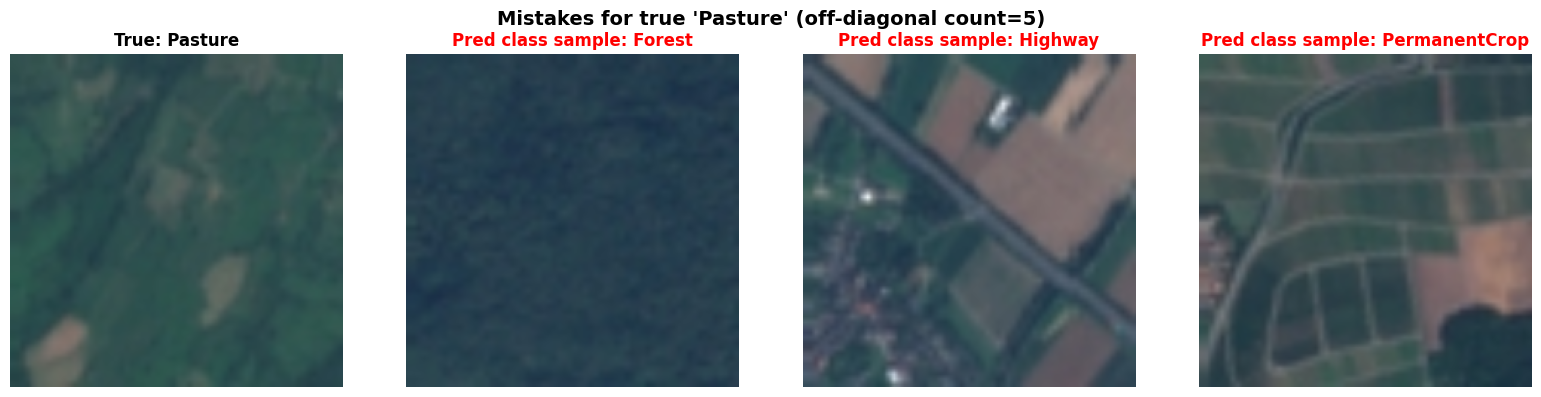

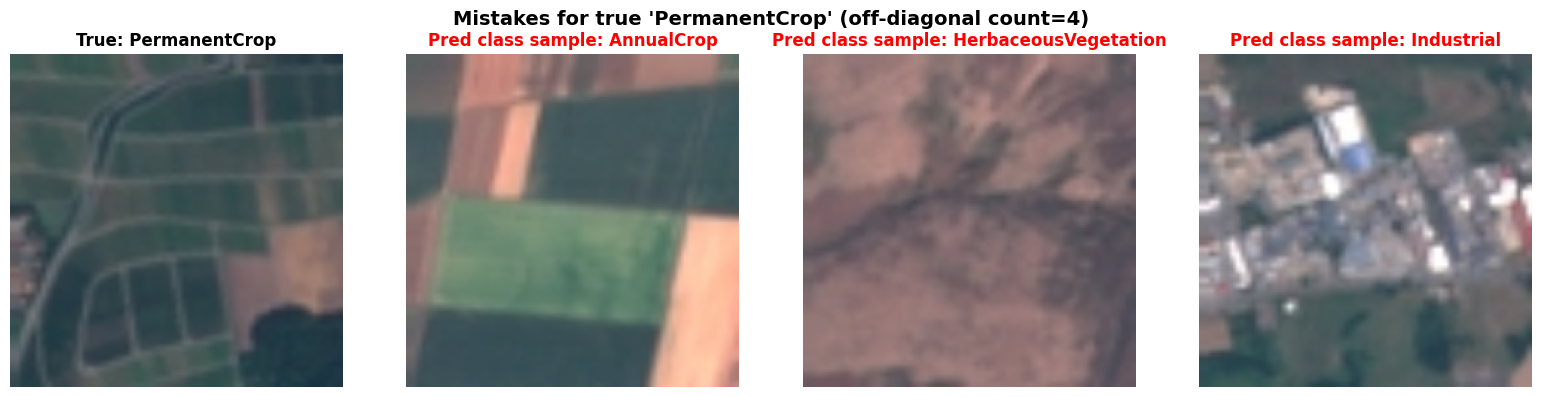

In [ ]:
# For any true class with >3 total mistakes in cm (row off-diagonal), show:
#   - 1 example image of the true class
#   - 1 example image for each distinct predicted class that appeared in that row

import matplotlib.pyplot as plt
import numpy as np

if 'cm' not in globals():
    raise RuntimeError("Confusion matrix `cm` not found. Please run Section 7 first to populate `cm`.")

class_names = info.features['label'].names
num_classes = len(class_names)

def get_one_image_by_label(dataset, label_id):
    """Return one preprocessed image (as np.array) from dataset matching label_id."""
    for img, lbl in dataset.unbatch():
        if int(lbl.numpy()) == label_id:
            return img.numpy()
    return None

for t in range(num_classes):
    row = cm[t]
    mistakes = row.sum() - row[t]
    if mistakes > 3:
        # predicted classes with nonzero confusions
        pred_classes = [p for p in range(num_classes) if p != t and row[p] > 0]
        if not pred_classes:
            continue

        # fetch one true image
        true_img = get_one_image_by_label(test_ds, t)
        if true_img is None:
            continue

        ncols = 1 + len(pred_classes)
        plt.figure(figsize=(4 * ncols, 4))

        # true image
        plt.subplot(1, ncols, 1)
        plt.imshow(np.clip((true_img + 1) / 2, 0, 1))
        plt.title(f"True: {class_names[t]}", fontweight='bold')
        plt.axis('off')

        # one example image per predicted class
        for idx, p in enumerate(pred_classes, start=2):
            pred_img = get_one_image_by_label(test_ds, p)
            if pred_img is None:
                continue
            plt.subplot(1, ncols, idx)
            plt.imshow(np.clip((pred_img + 1) / 2, 0, 1))
            plt.title(f"Pred class sample: {class_names[p]}", color='red', fontweight='bold')
            plt.axis('off')

        plt.suptitle(
            f"Mistakes for true '{class_names[t]}' (off-diagonal count={int(mistakes)})",
            fontsize=14, fontweight='bold'
        )
        plt.tight_layout()
        plt.show()